In [8]:
import json
import re
import pandas as pd

In [9]:
def extract_json_from_html(html_path, save_output=False):
    html_file = open(html_path, 'r')
    html = html_file.read()
    html_file.close()
    regex_pattern = r'(?<=require\.config\.params\["args"\].=.)[\s\S]*?;'
    data_txt = re.findall(regex_pattern, html)[0]

    # add quotations for json parser
    data_txt = data_txt.replace('matchId', '"matchId"')
    data_txt = data_txt.replace('matchCentreData', '"matchCentreData"')
    data_txt = data_txt.replace('matchCentreEventTypeJson', '"matchCentreEventTypeJson"')
    data_txt = data_txt.replace('formationIdNameMappings', '"formationIdNameMappings"')
    data_txt = data_txt.replace('};', '}')

    if save_output:
        # save json data to txt
        output_file = open(f"{html_path}.txt", "wt")
        n = output_file.write(data_txt)
        output_file.close()

    return data_txt

In [10]:
def extract_data_from_dict(data):
    # load data from json
    event_types_json = data["matchCentreEventTypeJson"]
    formation_mappings = data["formationIdNameMappings"]
    events_dict = data["matchCentreData"]["events"]
    teams_dict = {data["matchCentreData"]['home']['teamId']: data["matchCentreData"]['home']['name'],
                  data["matchCentreData"]['away']['teamId']: data["matchCentreData"]['away']['name']}
    players_dict = data["matchCentreData"]["playerIdNameDictionary"]
    # create players dataframe
    players_home_df = pd.DataFrame(data["matchCentreData"]['home']['players'])
    players_home_df["teamId"] = data["matchCentreData"]['home']['teamId']
    players_away_df = pd.DataFrame(data["matchCentreData"]['away']['players'])
    players_away_df["teamId"] = data["matchCentreData"]['away']['teamId']
    players_df = pd.concat([players_home_df, players_away_df])
    players_ids = data["matchCentreData"]["playerIdNameDictionary"]
    return events_dict, players_df, teams_dict

In [27]:
match_html_path = '../input/week2matches/Sampdoria 1-2 AC Milan - Serie A 2022_2023 Live.html'
json_data_txt = extract_json_from_html(match_html_path)
data = json.loads(json_data_txt)
events_dict, players_df, teams_dict = extract_data_from_dict(data)

In [28]:
players_df.head()

,playerId,shirtNo,name,position,height,weight,age,isFirstEleven,isManOfTheMatch,field,stats,subbedInPlayerId,subbedOutPeriod,subbedOutExpandedMinute,subbedInPeriod,subbedInExpandedMinute,subbedOutPlayerId,teamId
0,254692,1,Emil Audero,GK,190,83,25,True,False,home,"{'totalSaves': {'41': 1.0, '66': 1.0}, 'parrie...",NaN,NaN,NaN,NaN,NaN,NaN,271
1,84827,24,Bartosz Bereszynski,DR,183,77,30,True,False,home,"{'possession': {'1': 1.0, '4': 1.0, '5': 1.0, ...",74921.0,"{'value': 2, 'displayName': 'SecondHalf'}",62.0,NaN,NaN,NaN,271
2,109565,21,Jeison Murillo,DC,182,78,30,True,False,home,"{'possession': {'1': 1.0, '8': 1.0, '10': 1.0,...",NaN,NaN,NaN,NaN,NaN,NaN,271
3,130043,25,Alex Ferrari,DC,191,80,28,True,False,home,"{'possession': {'0': 1.0, '8': 1.0, '10': 1.0,...",NaN,NaN,NaN,NaN,NaN,NaN,271
4,343559,3,Tommaso Augello,DL,180,70,28,True,False,home,"{'possession': {'1': 1.0, '3': 1.0, '4': 1.0, ...",NaN,NaN,NaN,NaN,NaN,NaN,271


In [29]:
def get_passes_df(events_dict):
    df = pd.DataFrame(events_dict)
    df['eventType'] = df.apply(lambda row: row['type']['displayName'], axis=1)
    df['outcomeType'] = df.apply(lambda row: row['outcomeType']['displayName'], axis=1)

    # create receiver column based on the next event
    # this will be correct only for successfull passes
    df["receiver"] = df["playerId"].shift(-1)

    # filter only passes
    passes_ids = df.index[df['eventType'] == 'Pass']
    df_passes = df.loc[
        passes_ids, ["id", "x", "y", "endX", "endY", "teamId", "playerId", "receiver", "eventType", "outcomeType"]]

    return df_passes

In [30]:
passes_df = get_passes_df(events_dict)
passes_df.head()

,id,x,y,endX,endY,teamId,playerId,receiver,eventType,outcomeType
2,2.458195e+09,50.2,49.9,37.6,57.5,80,24444.0,402123.0,Pass,Successful
3,2.458195e+09,37.6,57.5,42.3,79.4,80,402123.0,386390.0,Pass,Successful
4,2.458195e+09,42.3,79.4,36.4,95.0,80,386390.0,303115.0,Pass,Successful
5,2.458195e+09,36.4,95.0,44.0,96.9,80,303115.0,349207.0,Pass,Successful
6,2.458195e+09,43.6,96.9,33.0,91.5,80,349207.0,303115.0,Pass,Successful


In [31]:
def get_passes_between_df(team_id, passes_df, players_df):
    # filter for only team
    passes_df = passes_df[passes_df["teamId"] == team_id]

    # add column with first eleven players only
    passes_df = passes_df.merge(players_df[["playerId", "isFirstEleven"]], on='playerId', how='left')
    # filter on first eleven column
    passes_df = passes_df[passes_df['isFirstEleven'] == True]

    # calculate mean positions for players
    average_locs_and_count_df = (passes_df.groupby('playerId')
                                 .agg({'x': ['mean'], 'y': ['mean', 'count']}))
    average_locs_and_count_df.columns = ['x', 'y', 'count']
    average_locs_and_count_df = average_locs_and_count_df.merge(players_df[['playerId', 'name', 'shirtNo', 'position']],
                                                                on='playerId', how='left')
    average_locs_and_count_df = average_locs_and_count_df.set_index('playerId')

    # calculate the number of passes between each position (using min/ max so we get passes both ways)
    passes_player_ids_df = passes_df.loc[:, ['id', 'playerId', 'receiver', 'teamId']]
    passes_player_ids_df['pos_max'] = (passes_player_ids_df[['playerId', 'receiver']].max(axis='columns'))
    passes_player_ids_df['pos_min'] = (passes_player_ids_df[['playerId', 'receiver']].min(axis='columns'))

    # get passes between each player
    passes_between_df = passes_player_ids_df.groupby(['pos_min', 'pos_max']).id.count().reset_index()
    passes_between_df.rename({'id': 'pass_count'}, axis='columns', inplace=True)

    # add on the location of each player so we have the start and end positions of the lines
    passes_between_df = passes_between_df.merge(average_locs_and_count_df, left_on='pos_min', right_index=True)
    passes_between_df = passes_between_df.merge(average_locs_and_count_df, left_on='pos_max', right_index=True,
                                                suffixes=['', '_end'])
    return passes_between_df, average_locs_and_count_df

In [32]:
home_team_id = list(teams_dict.keys())[0]  # selected home team
home_passes_between_df, home_average_locs_and_count_df = get_passes_between_df(home_team_id, passes_df, players_df)


In [33]:
away_team_id = list(teams_dict.keys())[1]  # selected home team
away_passes_between_df, away_average_locs_and_count_df = get_passes_between_df(away_team_id, passes_df, players_df)

In [34]:
!pip install mplsoccer

In [35]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import to_rgba
from mplsoccer import Pitch, FontManager

In [36]:
def pass_network_visualization(ax, passes_between_df, average_locs_and_count_df, flipped=False):
    MAX_LINE_WIDTH = 10
    MAX_MARKER_SIZE = 3000
    passes_between_df['width'] = (passes_between_df.pass_count / passes_between_df.pass_count.max() *
                                  MAX_LINE_WIDTH)
    average_locs_and_count_df['marker_size'] = (average_locs_and_count_df['count']
                                                / average_locs_and_count_df['count'].max() * MAX_MARKER_SIZE)

    MIN_TRANSPARENCY = 0.3
    color = np.array(to_rgba('#507293'))
    color = np.tile(color, (len(passes_between_df), 1))
    c_transparency = passes_between_df.pass_count / passes_between_df.pass_count.max()
    c_transparency = (c_transparency * (1 - MIN_TRANSPARENCY)) + MIN_TRANSPARENCY
    color[:, 3] = c_transparency

    pitch = Pitch(pitch_type='opta', pitch_color='#0D182E', line_color='#5B6378')
    pitch.draw(ax=ax)

    if flipped:
        passes_between_df['x'] = pitch.dim.right - passes_between_df['x']
        passes_between_df['y'] = pitch.dim.right - passes_between_df['y']
        passes_between_df['x_end'] = pitch.dim.right - passes_between_df['x_end']
        passes_between_df['y_end'] = pitch.dim.right - passes_between_df['y_end']
        average_locs_and_count_df['x'] = pitch.dim.right - average_locs_and_count_df['x']
        average_locs_and_count_df['y'] = pitch.dim.right - average_locs_and_count_df['y']

    pass_lines = pitch.lines(passes_between_df.x, passes_between_df.y,
                             passes_between_df.x_end, passes_between_df.y_end, lw=passes_between_df.width,
                             color=color, zorder=1, ax=ax)
    pass_nodes = pitch.scatter(average_locs_and_count_df.x, average_locs_and_count_df.y,
                               s=average_locs_and_count_df.marker_size, marker='h',
                               color='#FEFEFC', edgecolors='#FEFEFC', linewidth=1, alpha=1, ax=ax)
    for index, row in average_locs_and_count_df.iterrows():
        player_name = row["name"].split()
        player_initials = "".join(word[0] for word in player_name).upper()
        pitch.annotate(player_initials, xy=(row.x, row.y), c='#C4C4C4', va='center',
                       ha='center', size=14, ax=ax)

    return pitch

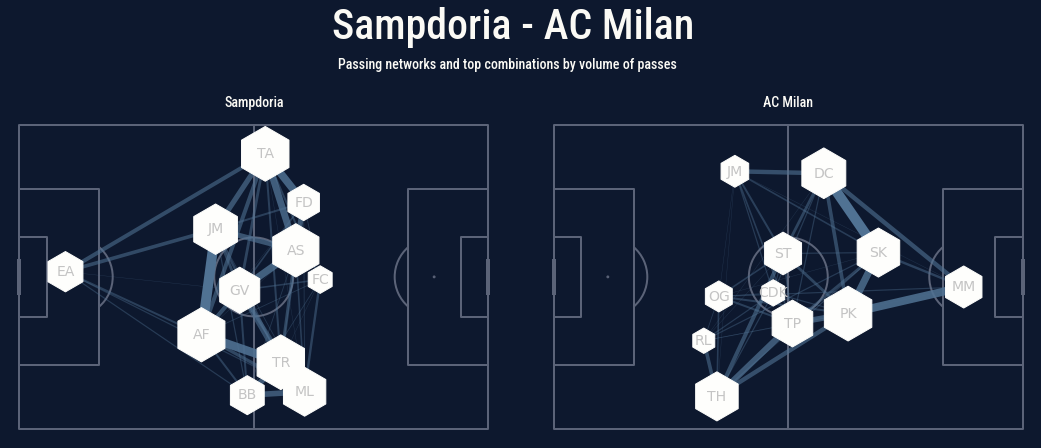

In [37]:
# create plot
fig, axes = plt.subplots(1, 2, figsize=(15, 8))
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=None)
axes = axes.flat
plt.tight_layout()
fig.set_facecolor("#0D182E")

# plot variables
main_color = '#FBFAF5'
font_bold = FontManager(("https://github.com/google/fonts/blob/main/apache/roboto/static/"
                         "RobotoCondensed-Medium.ttf?raw=true"))

# home team viz
pass_network_visualization(axes[0], home_passes_between_df, home_average_locs_and_count_df)
axes[0].set_title(teams_dict[home_team_id], color=main_color, fontsize=14, fontproperties=font_bold.prop)

# away team viz
pass_network_visualization(axes[1], away_passes_between_df, away_average_locs_and_count_df, flipped=True)
axes[1].set_title(teams_dict[away_team_id], color=main_color, fontsize=14, fontproperties=font_bold.prop)

plt.suptitle(f"{teams_dict[home_team_id]} - {teams_dict[away_team_id]}", color=main_color, fontsize=42, fontproperties=font_bold.prop)
subtitle = "Passing networks and top combinations by volume of passes"
plt.text(-10, 120, subtitle, horizontalalignment='center', verticalalignment='center', color=main_color, fontsize=14, fontproperties=font_bold.prop)
plt.savefig('MilanSamp.png', bbox_inches='tight')
plt.show()

In [38]:
away_passes_between_df.sort_values('pass_count',ascending=False)

,pos_min,pos_max,pass_count,x,y,count,name,shirtNo,position,x_end,y_end,count_end,name_end,shirtNo_end,position_end,width
7,20769.0,260498.0,25,69.233333,58.020000,45,Simon Kjaer,24,DC,57.579167,84.139583,48,Davide Calabria,2,DR,10.0
62,141646.0,391836.0,20,87.433333,46.669697,33,Mike Maignan,16,GK,62.760714,37.908929,56,Pierre Kalulu,20,DC,8.0
13,20769.0,391836.0,18,69.233333,58.020000,45,Simon Kjaer,24,DC,62.760714,37.908929,56,Pierre Kalulu,20,DC,7.2
92,303115.0,402123.0,15,34.771111,10.637778,45,Theo Hernández,19,DL,50.885366,34.636585,41,Tommaso Pobega,32,DMC,6.0
116,391836.0,402123.0,14,62.760714,37.908929,56,Pierre Kalulu,20,DC,50.885366,34.636585,41,Tommaso Pobega,32,DMC,5.6
58,141646.0,260498.0,11,87.433333,46.669697,33,Mike Maignan,16,GK,57.579167,84.139583,48,Davide Calabria,2,DR,4.4
82,260498.0,401098.0,11,57.579167,84.139583,48,Davide Calabria,2,DR,38.605263,84.784211,19,Junior Messias,30,AMR,4.4
89,303115.0,391836.0,11,34.771111,10.637778,45,Theo Hernández,19,DL,62.760714,37.908929,56,Pierre Kalulu,20,DC,4.4
85,303115.0,343501.0,10,34.771111,10.637778,45,Theo Hernández,19,DL,48.885294,57.711765,34,Sandro Tonali,8,DMC,4.0
86,303115.0,349207.0,9,34.771111,10.637778,45,Theo Hernández,19,DL,31.966667,28.966667,12,Rafael Leão,17,AML,3.6


In [39]:
home_passes_between_df.sort_values('pass_count',ascending=False)

,pos_min,pos_max,pass_count,x,y,count,name,shirtNo,position,x_end,y_end,count_end,name_end,shirtNo_end,position_end,width
65,109565.0,130043.0,25,41.866000,65.712000,50,Jeison Murillo,21,DC,38.844828,30.937931,58,Alex Ferrari,25,DC,10.0
22,31991.0,338073.0,23,55.783051,21.879661,59,Tomás Rincón,8,MC,60.868085,12.155319,47,Mehdi Léris,37,MR,9.2
16,31991.0,130043.0,21,55.783051,21.879661,59,Tomás Rincón,8,MC,38.844828,30.937931,58,Alex Ferrari,25,DC,8.4
48,80443.0,343559.0,19,60.661538,74.515385,26,Filip Djuricic,7,ML,52.466102,90.537288,59,Tommaso Augello,3,DL,7.6
106,333255.0,357388.0,18,58.987500,58.732143,56,Abdelhamid Sabiri,11,MC,47.016667,45.578571,42,Gonzalo Villar,4,DMC,7.2
105,333255.0,343559.0,17,58.987500,58.732143,56,Abdelhamid Sabiri,11,MC,52.466102,90.537288,59,Tommaso Augello,3,DL,6.8
14,31991.0,84827.0,14,55.783051,21.879661,59,Tomás Rincón,8,MC,48.640000,11.030000,30,Bartosz Bereszynski,24,DR,5.6
59,84827.0,338073.0,14,48.640000,11.030000,30,Bartosz Bereszynski,24,DR,60.868085,12.155319,47,Mehdi Léris,37,MR,5.6
68,109565.0,333255.0,13,41.866000,65.712000,50,Jeison Murillo,21,DC,58.987500,58.732143,56,Abdelhamid Sabiri,11,MC,5.2
70,109565.0,343559.0,13,41.866000,65.712000,50,Jeison Murillo,21,DC,52.466102,90.537288,59,Tommaso Augello,3,DL,5.2


In [17]:
away_passes_between_df['name'].value_counts()

Simon Kjaer            10
Mike Maignan            7
Olivier Giroud          6
Alessandro Florenzi     6
Ismaël Bennacer         6
Theo Hernández          5
Fikayo Tomori           3
Brahim Díaz             3
Rafael Leão             2
Alexis Saelemaekers     1
Name: name, dtype: int64

In [18]:
from itertools import product


In [19]:
Combination=list(product(away_passes_between_df['name'],away_passes_between_df['name_end']))


In [20]:
from collections import Counter

In [21]:
Counter(Combination)

Counter({('Simon Kjaer', 'Olivier Giroud'): 10,
         ('Simon Kjaer', 'Alessandro Florenzi'): 20,
         ('Simon Kjaer', 'Mike Maignan'): 30,
         ('Simon Kjaer', 'Ismaël Bennacer'): 40,
         ('Simon Kjaer', 'Theo Hernández'): 30,
         ('Simon Kjaer', 'Fikayo Tomori'): 50,
         ('Simon Kjaer', 'Brahim Díaz'): 70,
         ('Simon Kjaer', 'Rafael Leão'): 60,
         ('Simon Kjaer', 'Alexis Saelemaekers'): 90,
         ('Simon Kjaer', 'Tommaso Pobega'): 90,
         ('Olivier Giroud', 'Olivier Giroud'): 6,
         ('Olivier Giroud', 'Alessandro Florenzi'): 12,
         ('Olivier Giroud', 'Mike Maignan'): 18,
         ('Olivier Giroud', 'Ismaël Bennacer'): 24,
         ('Olivier Giroud', 'Theo Hernández'): 18,
         ('Olivier Giroud', 'Fikayo Tomori'): 30,
         ('Olivier Giroud', 'Brahim Díaz'): 42,
         ('Olivier Giroud', 'Rafael Leão'): 36,
         ('Olivier Giroud', 'Alexis Saelemaekers'): 54,
         ('Olivier Giroud', 'Tommaso Pobega'): 54,
       

In [22]:
df = pd.DataFrame.from_dict(Counter(Combination), orient='index').reset_index()


In [23]:
df2 = pd.DataFrame(df['index'].tolist(), index=df.index)


In [24]:
df2['passes']=df[0]

In [25]:
df2.to_csv('PassesCombinedMilan.csv')

In [26]:
df.sort_values(0)

,index,0
90,"(Alexis Saelemaekers, Olivier Giroud)",1
80,"(Rafael Leão, Olivier Giroud)",2
91,"(Alexis Saelemaekers, Alessandro Florenzi)",2
60,"(Fikayo Tomori, Olivier Giroud)",3
70,"(Brahim Díaz, Olivier Giroud)",3
...,...,...
38,"(Mike Maignan, Alexis Saelemaekers)",63
39,"(Mike Maignan, Tommaso Pobega)",63
6,"(Simon Kjaer, Brahim Díaz)",70
8,"(Simon Kjaer, Alexis Saelemaekers)",90


In [27]:
df.to_csv('CombinationsMilan.csv')

In [42]:
passes_df.to_csv('passes.csv')

In [43]:
xT_df = away_passes_between_df.loc[(away_passes_between_df['name']=='Ismaël Bennacer')]

In [44]:
xT_df

,pos_min,pos_max,pass_count,x,y,count,name,shirtNo,position,x_end,y_end,count_end,name_end,shirtNo_end,position_end,width


In [45]:
xT = pd.read_csv("../input/xthreat/xT_Grid.csv", header=None)
xT = np.array(xT)
xT_rows, xT_cols = xT.shape

In [35]:

xT # this is how our pitch is broken up

array([[0.00638303, 0.00779616, 0.00844854, 0.00977659, 0.01126267,
        0.01248344, 0.01473596, 0.0174506 , 0.02122129, 0.02756312,
        0.03485072, 0.0379259 ],
       [0.00750072, 0.00878589, 0.00942382, 0.0105949 , 0.01214719,
        0.0138454 , 0.01611813, 0.01870347, 0.02401521, 0.02953272,
        0.04066992, 0.04647721],
       [0.0088799 , 0.00977745, 0.01001304, 0.01110462, 0.01269174,
        0.01429128, 0.01685596, 0.01935132, 0.0241224 , 0.02855202,
        0.05491138, 0.06442595],
       [0.00941056, 0.01082722, 0.01016549, 0.01132376, 0.01262646,
        0.01484598, 0.01689528, 0.0199707 , 0.02385149, 0.03511326,
        0.10805102, 0.25745362],
       [0.00941056, 0.01082722, 0.01016549, 0.01132376, 0.01262646,
        0.01484598, 0.01689528, 0.0199707 , 0.02385149, 0.03511326,
        0.10805102, 0.25745362],
       [0.0088799 , 0.00977745, 0.01001304, 0.01110462, 0.01269174,
        0.01429128, 0.01685596, 0.01935132, 0.0241224 , 0.02855202,
        0.05491138,